# Preambule

In [1]:
import javabridge
import bioformats as bf
javabridge.start_vm(class_path=bf.JARS)

In [2]:
import matplotlib.pyplot as plt
%matplotlib notebook
# %config InlineBackend.figure_format = 'retina'

In [3]:
from collections import OrderedDict

In [4]:
import pandas as pd

In [5]:
from scipy.stats import distributions as dst

In [6]:
# from lesion.lifio import parse_xml_metadata
import numpy as np

In [7]:
# from sys import path as syspath
# from os.path import expanduser
# syspath.append(expanduser("~/Seafile/functions/"))

In [8]:
# from general_functions import autocorr, tally

In [157]:
def moving_average(a, n) :
    from numpy import cumsum
    ret = cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

## Parse metadata

In [9]:
from os import listdir

In [10]:
len([fn for fn in listdir("data") if fn.endswith(".nd2")])

8

CPU times: user 33.9 s, sys: 1.26 s, total: 35.2 s
Wall time: 27.5 s


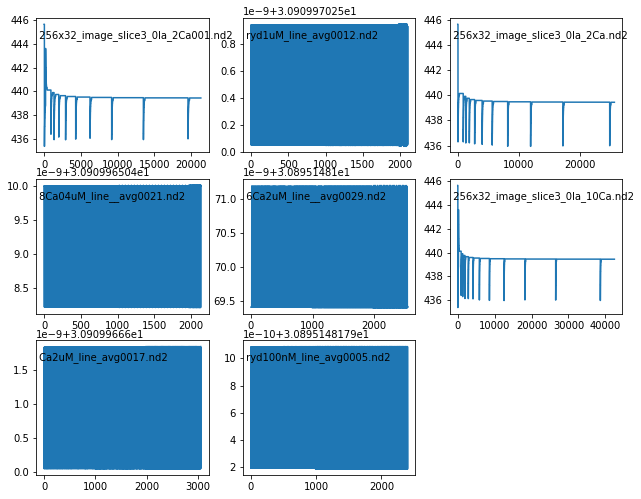

In [34]:
%%time
nr,nc = 3,3
fig, axs = plt.subplots(nr,nc,figsize=(nc*3.5,nr*2.8))
mdf = []
ia = 0
for filename in listdir("data"):
    if "nd2" not in filename: 
        continue
    ax = axs.flat[ia]
    md = bf.get_omexml_metadata("./data/"+filename)
    xml = bf.OMEXML(md)
    Nimages = xml.get_image_count()
    if Nimages!=1:
        print (f"{filename} has more than one image!?\nTaking only the first one...")
    im = xml.image(index=0)
    tmp = OrderedDict([("filename",filename)])
#     tmp.update(OrderedDict([(attrib,getattr(im,attrib)) for attrib in ["Name","AcquisitionDate"]]))
    for dim in "XYTCZ":
        tmp[dim] = getattr(im.Pixels, "Size"+dim)

    lines = md.replace("><",">\n<").splitlines()
    times = [float(l.split('"')[1]) for l in lines if "Plane" in l]
    dt = np.diff(times)
#     assert np.std(dt)/np.mean(dt)<1e-9

    freq = 1./np.mean(np.diff(times))

    tmp["Frequency"] = freq
    tmp["Total_time"] = dt.sum()
    ax.plot(1./dt)
    ax.text(0,1,"\n "+filename,va="top", transform=ax.transAxes)
    mdf += [tmp]
    ia += 1
#     break
for ax in axs.flat[ia:]:
    ax.remove()

In [35]:
mdf = pd.DataFrame(mdf)

In [36]:
try:
    mdf["AcquisitionDate"] = pd.to_datetime(mdf["AcquisitionDate"])
except:
    pass

In [37]:
mdf["Total Pixels"] = mdf["X"]*mdf["Y"]*mdf["T"]

In [38]:
mdf#.sort_values("Total Pixels")

,filename,X,Y,T,C,Z,Frequency,Total_time,Total Pixels
0,256x32_image_slice3_0la_2Ca001.nd2,256,32,21323,1,1,439.443719,48.520434,174678016
1,ryd1uM_line_avg0012.nd2,512,512,2102,1,1,30.909970,67.971596,551026688
2,256x32_image_slice3_0la_2Ca.nd2,256,32,25604,1,1,439.439949,58.262796,209747968
3,8Ca04uM_line__avg0021.nd2,512,512,2136,1,1,30.909965,69.071576,559939584
4,6Ca2uM_line__avg0029.nd2,512,512,2542,1,1,30.895148,82.245924,666370048
5,256x32_image_slice3_0la_10Ca.nd2,256,32,42436,1,1,439.439303,96.566237,347635712
6,Ca2uM_line_avg0017.nd2,512,512,3063,1,1,30.909967,99.061899,802947072
7,ryd100nM_line_avg0005.nd2,512,512,2402,1,1,30.895148,77.714468,629669888


In [39]:
# %%time
# planes = []
# for l in lines:
#     if "Plane" in l:
#         txt = "dict("+",".join(l.replace('"s"',"'s'").replace('"','')[:-2].split()[1:])+")"
#         dd = eval(txt)
#         planes += [dd]
# #         if len(planes)>1000: break

# planes = pd.DataFrame(planes)

# choose individual image

In [ ]:
Nsample = 1e6

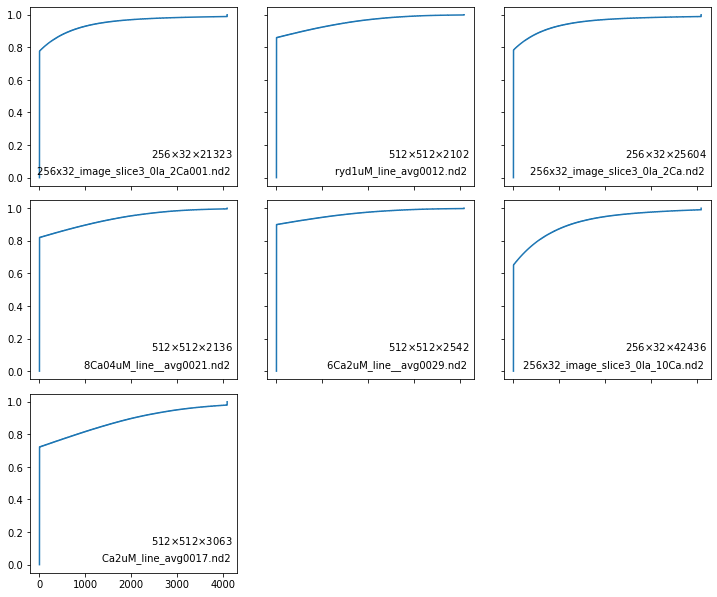

In [86]:
nr,nc = 3,3
fig,axs = plt.subplots(nr,nc,figsize=(nc*3.4,nr*2.8), sharex=True, sharey=True)
for ia,idx in enumerate(range(len(mdf))):
    try:
        ax = axs.flat[ia]
    except:
        break
    filename = mdf.loc[idx,"filename"]
    dimensions = mdf.loc[idx,list("XYZCT")]
    rdr = bf.ImageReader("./data/"+filename, perform_init=True)
    Ts = np.random.choice(range(dimensions["T"]),int(Nsample/(dimensions.X*dimensions.Y)))
    sampleSnapshots = np.array([
            rdr.read(rescale=False,t=t) for t in Ts
        ])
    # for some reason, only the middle array in the last dimension is non-zero
    assert [~np.all(ss==0) for ss in sampleSnapshots.T]==[False,True,False]
    # so I take only that
    sampleSnapshots = sampleSnapshots.T[1].T

    x = sampleSnapshots.flatten()
    ax.step(sorted(x), np.linspace(0,1,len(x)+1)[1:])
    ax.text(1,.15,r"$%i{\times}%i{\times}%i$  "%tuple(dimensions[list("XYT")]), 
            ha="right",va="bottom",transform=ax.transAxes)
    ax.text(1,.05,mdf.loc[idx,"filename"]+"  ", 
            ha="right",va="bottom",transform=ax.transAxes)
#     break
for ax in axs.flat[ia:]:
    ax.remove()
fig.tight_layout()

# Check individual image

In [87]:
mdf

,filename,X,Y,T,C,Z,Frequency,Total_time,Total Pixels
0,256x32_image_slice3_0la_2Ca001.nd2,256,32,21323,1,1,439.443719,48.520434,174678016
1,ryd1uM_line_avg0012.nd2,512,512,2102,1,1,30.909970,67.971596,551026688
2,256x32_image_slice3_0la_2Ca.nd2,256,32,25604,1,1,439.439949,58.262796,209747968
3,8Ca04uM_line__avg0021.nd2,512,512,2136,1,1,30.909965,69.071576,559939584
4,6Ca2uM_line__avg0029.nd2,512,512,2542,1,1,30.895148,82.245924,666370048
5,256x32_image_slice3_0la_10Ca.nd2,256,32,42436,1,1,439.439303,96.566237,347635712
6,Ca2uM_line_avg0017.nd2,512,512,3063,1,1,30.909967,99.061899,802947072
7,ryd100nM_line_avg0005.nd2,512,512,2402,1,1,30.895148,77.714468,629669888


In [162]:
idx = 0
filename = mdf.loc[idx,"filename"]
dimensions = mdf.loc[idx,list("XYZCT")]
rdr = bf.ImageReader("./data/"+filename, perform_init=True)
image = np.array([
            rdr.read(rescale=False,t=t) for t in range(dimensions["T"])
        ])

In [163]:
assert [~np.all(ss==0) for ss in image.T]==[False,True,False]
image = image.T[1].T

In [164]:
image.shape

(21323, 32, 256)

In [165]:
if "line" in filename:
    image = np.vstack(image)

In [166]:
image.shape

(21323, 32, 256)

In [167]:
meanValue = np.mean(image, axis=0)
imax = np.array(np.where(meanValue==meanValue.max())).T

In [168]:
imax

array([[ 17, 104],
       [ 17, 106],
       [ 17, 107],
       [ 17, 108],
       [ 18, 103],
       [ 18, 104],
       [ 18, 105],
       [ 18, 106],
       [ 18, 107],
       [ 18, 108],
       [ 18, 109],
       [ 19, 104],
       [ 19, 105],
       [ 19, 106],
       [ 19, 107],
       [ 19, 108],
       [ 19, 109],
       [ 20, 105],
       [ 20, 106],
       [ 20, 107],
       [ 20, 108],
       [ 20, 109],
       [ 20, 110]])

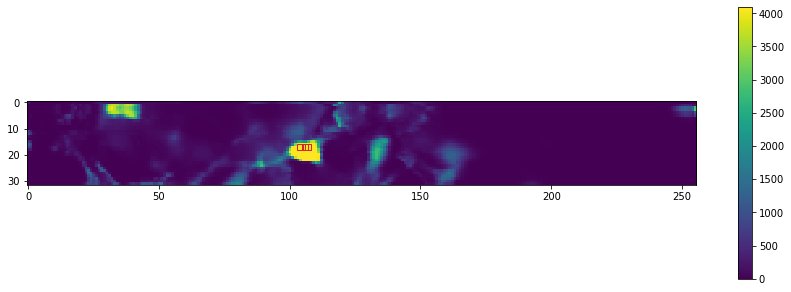

In [173]:
plt.figure(figsize=(15,5))
if "line" in filename:
    plt.plot(meanValue)
    imax = imax.flatten()
else:
    plt.imshow(meanValue)
    plt.colorbar()
    for x,y in imax[:3]:
        plt.plot(y,x,"C3s",mfc="none")

In [174]:
time = np.arange(len(image))*mdf.loc[idx,"Total_time"]/len(image)

In [189]:
image.shape

(21323, 32, 256)

## only for line scans

In [195]:
poi = imax[0]
# poi = 200

In [182]:
plt.figure(figsize=(13,3))
plt.plot(time,image[:,poi])
plt.xlabel("time [s]");

IndexError: index 104 is out of bounds for axis 1 with size 32

<Figure size 936x216 with 0 Axes>

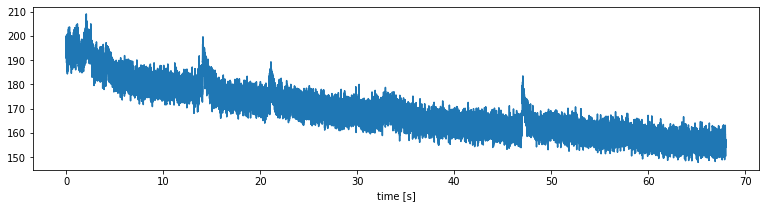

In [161]:
plt.figure(figsize=(13,3))
dtForAvg = 100
dxForAvg = 20
x = moving_average( time, dtForAvg)
y = moving_average(image[:,min(poi-dxForAvg,0) : max(poi+dxForAvg,image.shape[1])].mean(axis=1), dtForAvg)
plt.plot(x,y)
plt.xlabel("time [s]");

## when NOT line scan

In [272]:
from matplotlib.patches import Rectangle

In [244]:
x0,y0 = 20,100

In [245]:
image.shape

(21323, 32, 256)

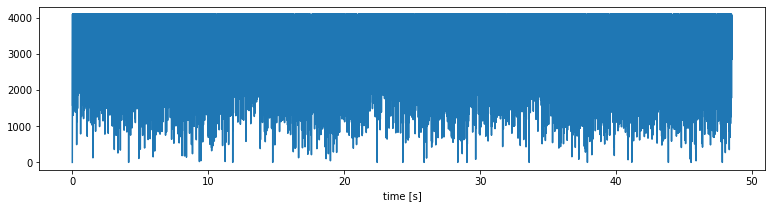

In [246]:
plt.figure(figsize=(13,3))
plt.plot(time,image[:,x0,y0])
plt.xlabel("time [s]");

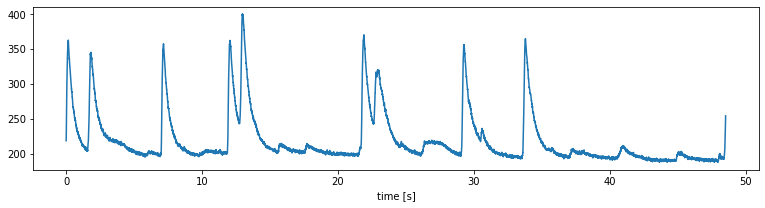

In [247]:
plt.figure(figsize=(13,3))
dtForAvg = 10
dxForAvg = 5
x = moving_average( time, dtForAvg)
y = moving_average(image[:,
                         min(x0-dxForAvg,0) : max(x0+dxForAvg,image.shape[1]),
                         min(y0-dxForAvg,0) : max(y0+dxForAvg,image.shape[2])
                        ].mean(axis=(1,2)), dtForAvg)
plt.plot(x,y)
plt.xlabel("time [s]");

In [301]:
x0,y0 = 140,6

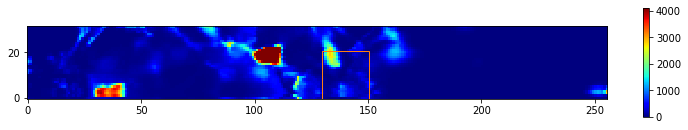

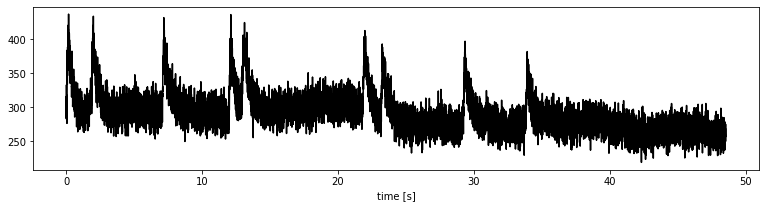

In [315]:
dtForAvg = 3
# to integrate all image, put some large values
# for a single pixel defined by x0 and y0, put zeros
dxForAvg = 10
dyForAvg = 10
plt.figure(figsize=(13,2))
ax = plt.gca()
plt.imshow(meanValue, cmap="jet", origin="bottom")
pc = Rectangle((max(x0-dxForAvg,0)-.5, max(y0-dyForAvg,0)-.5),2*dxForAvg+1,2*dyForAvg+1,facecolor="none", edgecolor="C1")
ax.add_patch(pc)
plt.colorbar()
plt.show()

plt.figure(figsize=(13,3))
x = moving_average( time, dtForAvg)
y = moving_average(image[:,
                         max(y0-dxForAvg,0) : min(y0+dxForAvg+1,image.shape[1]),
                         max(x0-dxForAvg,0) : min(x0+dxForAvg+1,image.shape[2]),
                        ].mean(axis=(1,2)), dtForAvg)
plt.plot(x,y,"k")
plt.xlabel("time [s]");
# plt.xlim(6.7,7.5)

In [2]:
javabridge.kill_vm()

NameError: name 'javabridge' is not defined